In [1]:
%%capture
!git clone https://github.com/hammaad2002/Solar-Irradiance-Forecasting.git
!pip install torchmetrics

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Assuming your DataFrame is named 'df'
desired_starting_row = 3
df = pd.read_csv('/kaggle/working/Solar-Irradiance-Forecasting/Solar Irradiance Dataset/2017Solar.csv', skiprows=desired_starting_row - 1)
df

,Year,Month,Day,Hour,Minute,GHI,Temperature,Dew Point,Relative Humidity,Pressure,Wind Direction,Wind Speed,Precipitable Water
0,2017,1,1,0,0,0,10.6,-17.4,12.29,949,103,0.7,0.7
1,2017,1,1,0,15,0,10.5,-17.4,12.37,949,107,0.7,0.7
2,2017,1,1,0,30,0,10.4,-17.4,12.45,949,111,0.7,0.7
3,2017,1,1,0,45,0,10.2,-17.3,12.74,949,115,0.7,0.7
4,2017,1,1,1,0,0,10.1,-17.3,12.83,949,120,0.7,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,2017,12,31,22,45,0,11.2,-17.4,11.78,950,81,0.8,0.7
35036,2017,12,31,23,0,0,11.1,-17.4,11.86,950,85,0.8,0.7
35037,2017,12,31,23,15,0,11.0,-17.4,11.93,949,89,0.7,0.7
35038,2017,12,31,23,30,0,10.9,-17.4,12.01,949,94,0.7,0.7


In [4]:
workingDf = df.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis = 1)
workingDf

,GHI,Temperature,Dew Point,Relative Humidity,Pressure,Wind Direction,Wind Speed,Precipitable Water
0,0,10.6,-17.4,12.29,949,103,0.7,0.7
1,0,10.5,-17.4,12.37,949,107,0.7,0.7
2,0,10.4,-17.4,12.45,949,111,0.7,0.7
3,0,10.2,-17.3,12.74,949,115,0.7,0.7
4,0,10.1,-17.3,12.83,949,120,0.7,0.7
...,...,...,...,...,...,...,...,...
35035,0,11.2,-17.4,11.78,950,81,0.8,0.7
35036,0,11.1,-17.4,11.86,950,85,0.8,0.7
35037,0,11.0,-17.4,11.93,949,89,0.7,0.7
35038,0,10.9,-17.4,12.01,949,94,0.7,0.7


In [5]:
columns = workingDf.columns.tolist()
columns[0], columns[-1] = columns[-1], columns[0]
workingDf = workingDf[columns]
workingDf

,Precipitable Water,Temperature,Dew Point,Relative Humidity,Pressure,Wind Direction,Wind Speed,GHI
0,0.7,10.6,-17.4,12.29,949,103,0.7,0
1,0.7,10.5,-17.4,12.37,949,107,0.7,0
2,0.7,10.4,-17.4,12.45,949,111,0.7,0
3,0.7,10.2,-17.3,12.74,949,115,0.7,0
4,0.7,10.1,-17.3,12.83,949,120,0.7,0
...,...,...,...,...,...,...,...,...
35035,0.7,11.2,-17.4,11.78,950,81,0.8,0
35036,0.7,11.1,-17.4,11.86,950,85,0.8,0
35037,0.7,11.0,-17.4,11.93,949,89,0.7,0
35038,0.7,10.9,-17.4,12.01,949,94,0.7,0


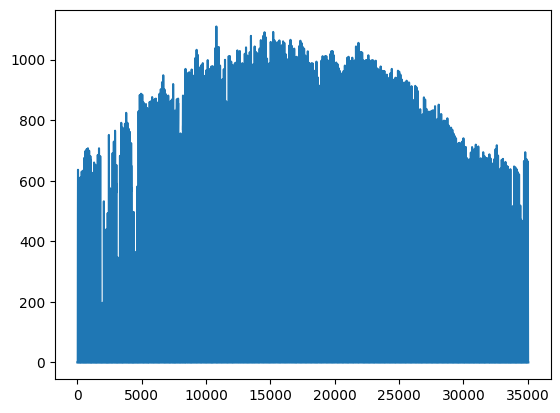

In [6]:
target = workingDf['GHI']
target.plot()
plt.show()

In [7]:
random_day = random.randint(1, 365)
random_day

186

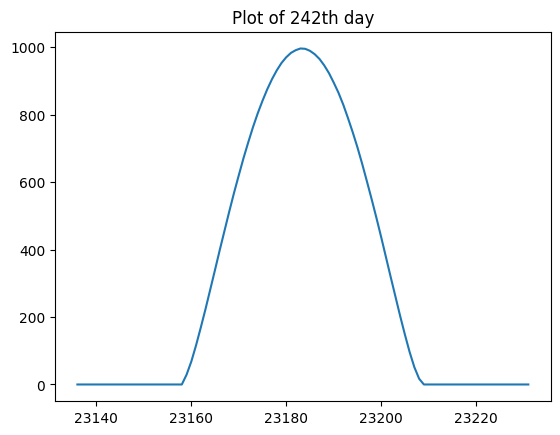

In [8]:
random_day = random.randint(4, 365) # starting from 4th day so that I can write "th" in the title :)
target = workingDf['GHI'][(random_day-1)*96:(random_day*96)]
target.plot()
plt.title(str(f"Plot of {random_day}th day"))
plt.show()

In [9]:
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(workingDf), columns=workingDf.columns)
df_normalized.head(10) # this normalizes the data in between range [0, 1]

,Precipitable Water,Temperature,Dew Point,Relative Humidity,Pressure,Wind Direction,Wind Speed,GHI
0,0.166667,0.291743,0.236287,0.122209,0.633333,0.286111,0.043860,0.0
1,0.166667,0.289908,0.236287,0.123159,0.633333,0.297222,0.043860,0.0
2,0.166667,0.288073,0.236287,0.124109,0.633333,0.308333,0.043860,0.0
3,0.166667,0.284404,0.238397,0.127553,0.633333,0.319444,0.043860,0.0
4,0.166667,0.282569,0.238397,0.128622,0.633333,0.333333,0.043860,0.0
5,0.166667,0.280734,0.238397,0.129572,0.633333,0.344444,0.035088,0.0
6,0.166667,0.278899,0.238397,0.130641,0.633333,0.355556,0.035088,0.0
7,0.166667,0.277064,0.240506,0.132660,0.633333,0.366667,0.035088,0.0
8,0.166667,0.275229,0.240506,0.133729,0.633333,0.377778,0.035088,0.0
9,0.166667,0.273394,0.240506,0.134679,0.633333,0.394444,0.035088,0.0


In [10]:
class simpleRNN(nn.Module):
    def __init__(self, features = 8, prediction = 1, window = 288, horizon = 1):
        super(simpleRNN, self).__init__()

        self.layer1 = nn.RNN(input_size = 8, hidden_size = 128, 
                             num_layers = 1, bias = True, 
                             batch_first = True, dropout = 0.2)
        
        self.activation1 = nn.Tanh()
        
        self.layer2 = nn.RNN(input_size = 128, hidden_size = 64,
                             num_layers = 1, bias = True,
                             batch_first = True, dropout = 0.2)

        self.activation2 = nn.Tanh()
        
        self.layer3 = nn.RNN(input_size = 64, hidden_size = 32,
                             num_layers = 1, bias = True,
                             batch_first = True, dropout = 0.2)
        
        self.activation3 = nn.Tanh()
        
        self.layer4 = nn.Linear(in_features = 32, out_features = 1)
       
        self.activation4 = nn.GELU()
        
        self.drop = nn.Dropout(p=0.5)

        self.layer5 = nn.Linear(in_features = window, out_features = horizon)

        self.activation5 = nn.GELU()

    def forward(self, x):

        x = self.layer1(x)
        x = self.activation1(x[0])
        x = self.layer2(x)
        x = self.activation2(x[0])
        x = self.layer3(x)
        x = self.activation3(x[0])
        x = self.layer4(x)
        x = self.activation4(x)
        x = self.drop(x)
        x = x.transpose(1, 2)
        x = self.layer5(x)
        x = self.activation5(x)
        return x

In [11]:
per_day_readings = 4 * 24
window_length = 3 * per_day_readings    # we want our model to look back at the data of 3 days
horizon = 1                             # and then predict the next 15 minute reading

In [12]:
df = df_normalized.values
stride = 1
x = []
y = []
for i in tqdm(range(0, len(df) - window_length, stride)):
    x.append(df[i:window_length+i, : ]) #GHI included but its past values only
    y.append(df[window_length+i,-1])                  #next GHI value

  0%|          | 0/34752 [00:00<?, ?it/s]

In [13]:
x = np.array(x)
y = np.array(y)
print(x.shape)
print(y.shape)

(34752, 288, 8)
(34752,)


In [14]:
x[45]

array([[0.36111111, 0.55779817, 0.50843882, ..., 0.71388889, 0.09649123,
        0.56176736],
       [0.36111111, 0.56330275, 0.50632911, ..., 0.73888889, 0.11403509,
        0.56988278],
       [0.36111111, 0.56697248, 0.50632911, ..., 0.76111111, 0.12280702,
        0.57348963],
       ...,
       [0.33333333, 0.46238532, 0.66666667, ..., 0.45277778, 0.13157895,
        0.50405771],
       [0.33333333, 0.46788991, 0.66666667, ..., 0.66944444, 0.13157895,
        0.52569883],
       [0.33333333, 0.47522936, 0.66666667, ..., 0.88888889, 0.14035088,
        0.54102795]])

In [15]:
y[44]

0.5410279531109107

In [16]:
# splitting our dataset into two parts one will be training set and the other will be testing set
# Lets store last 5 days as our test set
x_train = x[:-per_day_readings*5]
y_train = y[:-per_day_readings*5]
x_test  = x[len(y) - per_day_readings*5:]
y_test  = y[len(y) - per_day_readings*5:]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(34272, 288, 8)
(34272,)
(480, 288, 8)
(480,)


In [17]:
# finding the device of our environment
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

In [18]:
# converting our dataset to pytorch tensors for forwarding passing
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

In [19]:
amp = True # If we want the model to be trained faster

In [20]:
# Now we towards training the model
if amp:
    use_amp = True
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

In [21]:
set_epochs = 50

In [22]:
# initializing the model first before training
features = 8
prediction = 1

modelRNN = simpleRNN(features = features, prediction = prediction, 
                  window = window_length, horizon = horizon)

modelRNN = modelRNN.to(device)

In [23]:
modelRNN

simpleRNN(
  (layer1): RNN(8, 128, batch_first=True, dropout=0.2)
  (activation1): Tanh()
  (layer2): RNN(128, 64, batch_first=True, dropout=0.2)
  (activation2): Tanh()
  (layer3): RNN(64, 32, batch_first=True, dropout=0.2)
  (activation3): Tanh()
  (layer4): Linear(in_features=32, out_features=1, bias=True)
  (activation4): GELU(approximate='none')
  (drop): Dropout(p=0.5, inplace=False)
  (layer5): Linear(in_features=288, out_features=1, bias=True)
  (activation5): GELU(approximate='none')
)

In [24]:
# Lets define loss function and optimizer
criterion = MeanAbsoluteError().to(device)                         # MAE
metricc = MeanAbsolutePercentageError().to(device)                 # MAPE metric
optimizer = optim.AdamW(modelRNN.parameters(), lr=1e-4, weight_decay= 1e-5)               # Adam  TRY THIS : , 

num_epochs = set_epochs
batch_size = 128

loss_info_RNN = []
metric_info_RNN = []

for epoch in tqdm(range(num_epochs)):

    running_loss = 0.0                                             # MAE Loss
    running_metric = 0.0                                           # MAPE metric
    
    for i in tqdm(range(0, len(x_train_tensor), batch_size), desc=f"Epoch {epoch+1}"):

        # Get batch of inputs and targets
        batch_x = x_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        # Reshape input tensor
        batch_x = batch_x.view(-1, window_length, features)
        
        if amp:

            with torch.autocast(device_type= 'cuda', dtype=torch.float16, enabled=use_amp):
                # Forward pass
                outputs = modelRNN(batch_x)
                
                if batch_size == 1:
                    loss = criterion(outputs.view(-1), torch.tensor([batch_y]))
                    metric = metricc(outputs.view(-1), torch.tensor([batch_y]))

                else:
                    loss = criterion(outputs.view(-1), batch_y)
                    metric = metricc(outputs.view(-1), batch_y)
            
            # Backward pass and optimization
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update() 

        else:       

            # Forward pass
            outputs = modelRNN(batch_x)

            if batch_size == 1:
                loss = criterion(outputs.view(-1), torch.tensor([batch_y]))
                metric = metricc(outputs.view(-1), torch.tensor([batch_y]))

            else:
                loss = criterion(outputs.view(-1), batch_y)
                metric = metricc(outputs.view(-1), batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

        # Zero the parameter gradients
        optimizer.zero_grad(set_to_none=True)

        running_loss += loss.item()
        running_metric += metric.item()

    # Calculate epoch loss and metric
    epoch_loss = running_loss / (len(x_train) / batch_size)
    epoch_metric = running_metric / (len(x_train) / batch_size)
    loss_info_RNN.append(epoch_loss)
    metric_info_RNN.append(epoch_metric)
    print("-"*25, f"Epoch {epoch + 1}","-"*25)
    print(f"Epoch {epoch+1} MAE loss: {epoch_loss:.9f}")
    print(f"Epoch {epoch+1} MAPE metric: {epoch_metric:.9f}")

print("Training complete!")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 1 -------------------------
Epoch 1 MAE loss: 0.182515843
Epoch 1 MAPE metric: 20061.512434987


Epoch 2:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 2 -------------------------
Epoch 2 MAE loss: 0.098859754
Epoch 2 MAPE metric: 28766.278262868


Epoch 3:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 3 -------------------------
Epoch 3 MAE loss: 0.085825185
Epoch 3 MAPE metric: 24442.985542134


Epoch 4:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 4 -------------------------
Epoch 4 MAE loss: 0.079281020
Epoch 4 MAPE metric: 21982.346638655


Epoch 5:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 5 -------------------------
Epoch 5 MAE loss: 0.074807491
Epoch 5 MAPE metric: 20240.900556577


Epoch 6:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 6 -------------------------
Epoch 6 MAE loss: 0.069951596
Epoch 6 MAPE metric: 18556.908671802


Epoch 7:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 7 -------------------------
Epoch 7 MAE loss: 0.066939299
Epoch 7 MAPE metric: 17415.936606413


Epoch 8:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 8 -------------------------
Epoch 8 MAE loss: 0.064464292
Epoch 8 MAPE metric: 16331.815964928


Epoch 9:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 9 -------------------------
Epoch 9 MAE loss: 0.062256676
Epoch 9 MAPE metric: 15137.436436814


Epoch 10:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 10 -------------------------
Epoch 10 MAE loss: 0.060506719
Epoch 10 MAPE metric: 14318.559215613


Epoch 11:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 11 -------------------------
Epoch 11 MAE loss: 0.059315581
Epoch 11 MAPE metric: 13849.194045066


Epoch 12:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 12 -------------------------
Epoch 12 MAE loss: 0.057483680
Epoch 12 MAPE metric: 13181.209628122


Epoch 13:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 13 -------------------------
Epoch 13 MAE loss: 0.056446893
Epoch 13 MAPE metric: 12613.056892288


Epoch 14:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 14 -------------------------
Epoch 14 MAE loss: 0.054419684
Epoch 14 MAPE metric: 11902.685568759


Epoch 15:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 15 -------------------------
Epoch 15 MAE loss: 0.053966686
Epoch 15 MAPE metric: 12103.248045051


Epoch 16:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 16 -------------------------
Epoch 16 MAE loss: 0.053249151
Epoch 16 MAPE metric: 11065.606907607


Epoch 17:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 17 -------------------------
Epoch 17 MAE loss: 0.052500790
Epoch 17 MAPE metric: 11150.660643164


Epoch 18:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 18 -------------------------
Epoch 18 MAE loss: 0.051557939
Epoch 18 MAPE metric: 10385.904617837


Epoch 19:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 19 -------------------------
Epoch 19 MAE loss: 0.051219153
Epoch 19 MAPE metric: 10386.111922634


Epoch 20:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 20 -------------------------
Epoch 20 MAE loss: 0.050937142
Epoch 20 MAPE metric: 9921.168183940


Epoch 21:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 21 -------------------------
Epoch 21 MAE loss: 0.050237935
Epoch 21 MAPE metric: 9790.566315068


Epoch 22:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 22 -------------------------
Epoch 22 MAE loss: 0.049540989
Epoch 22 MAPE metric: 9487.459531469


Epoch 23:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 23 -------------------------
Epoch 23 MAE loss: 0.049405822
Epoch 23 MAPE metric: 9029.844052725


Epoch 24:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 24 -------------------------
Epoch 24 MAE loss: 0.049091292
Epoch 24 MAPE metric: 9067.772627801


Epoch 25:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 25 -------------------------
Epoch 25 MAE loss: 0.048624389
Epoch 25 MAPE metric: 8673.093394389


Epoch 26:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 26 -------------------------
Epoch 26 MAE loss: 0.047665889
Epoch 26 MAPE metric: 8309.284063886


Epoch 27:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 27 -------------------------
Epoch 27 MAE loss: 0.047321135
Epoch 27 MAPE metric: 8243.310708268


Epoch 28:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 28 -------------------------
Epoch 28 MAE loss: 0.046995585
Epoch 28 MAPE metric: 7930.386555534


Epoch 29:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 29 -------------------------
Epoch 29 MAE loss: 0.047286186
Epoch 29 MAPE metric: 8096.958300508


Epoch 30:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 30 -------------------------
Epoch 30 MAE loss: 0.046491747
Epoch 30 MAPE metric: 7687.361443015


Epoch 31:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 31 -------------------------
Epoch 31 MAE loss: 0.046377161
Epoch 31 MAPE metric: 7682.835737811


Epoch 32:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 32 -------------------------
Epoch 32 MAE loss: 0.045876936
Epoch 32 MAPE metric: 7294.619136066


Epoch 33:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 33 -------------------------
Epoch 33 MAE loss: 0.045985525
Epoch 33 MAPE metric: 7067.389335682


Epoch 34:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 34 -------------------------
Epoch 34 MAE loss: 0.045469213
Epoch 34 MAPE metric: 7044.991655907


Epoch 35:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 35 -------------------------
Epoch 35 MAE loss: 0.045401923
Epoch 35 MAPE metric: 6898.531345741


Epoch 36:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 36 -------------------------
Epoch 36 MAE loss: 0.044865944
Epoch 36 MAPE metric: 6868.717287436


Epoch 37:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 37 -------------------------
Epoch 37 MAE loss: 0.044535436
Epoch 37 MAPE metric: 6553.304098462


Epoch 38:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 38 -------------------------
Epoch 38 MAE loss: 0.044360815
Epoch 38 MAPE metric: 6374.737110469


Epoch 39:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 39 -------------------------
Epoch 39 MAE loss: 0.044250704
Epoch 39 MAPE metric: 6102.170692365


Epoch 40:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 40 -------------------------
Epoch 40 MAE loss: 0.043820015
Epoch 40 MAPE metric: 6029.443403143


Epoch 41:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 41 -------------------------
Epoch 41 MAE loss: 0.043581534
Epoch 41 MAPE metric: 6006.461867560


Epoch 42:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 42 -------------------------
Epoch 42 MAE loss: 0.043308494
Epoch 42 MAPE metric: 5818.335704073


Epoch 43:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 43 -------------------------
Epoch 43 MAE loss: 0.043088408
Epoch 43 MAPE metric: 5635.373719800


Epoch 44:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 44 -------------------------
Epoch 44 MAE loss: 0.042698255
Epoch 44 MAPE metric: 5570.884978992


Epoch 45:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 45 -------------------------
Epoch 45 MAE loss: 0.042894295
Epoch 45 MAPE metric: 5659.186996674


Epoch 46:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 46 -------------------------
Epoch 46 MAE loss: 0.042366418
Epoch 46 MAPE metric: 5464.444605837


Epoch 47:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 47 -------------------------
Epoch 47 MAE loss: 0.042426345
Epoch 47 MAPE metric: 5440.546467415


Epoch 48:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 48 -------------------------
Epoch 48 MAE loss: 0.042589650
Epoch 48 MAPE metric: 5369.528256485


Epoch 49:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 49 -------------------------
Epoch 49 MAE loss: 0.041935742
Epoch 49 MAPE metric: 5305.461932299


Epoch 50:   0%|          | 0/268 [00:00<?, ?it/s]

------------------------- Epoch 50 -------------------------
Epoch 50 MAE loss: 0.041833393
Epoch 50 MAPE metric: 5342.002870419
Training complete!


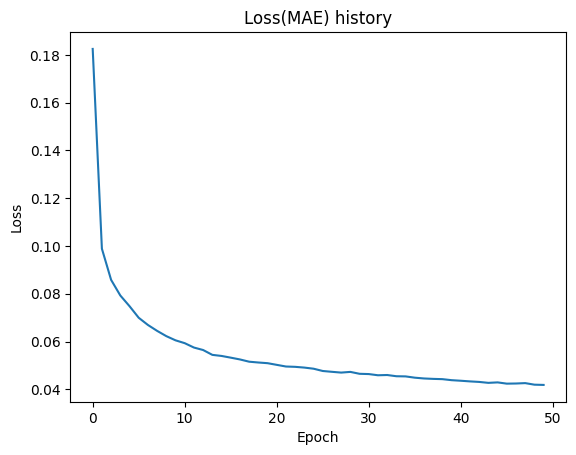

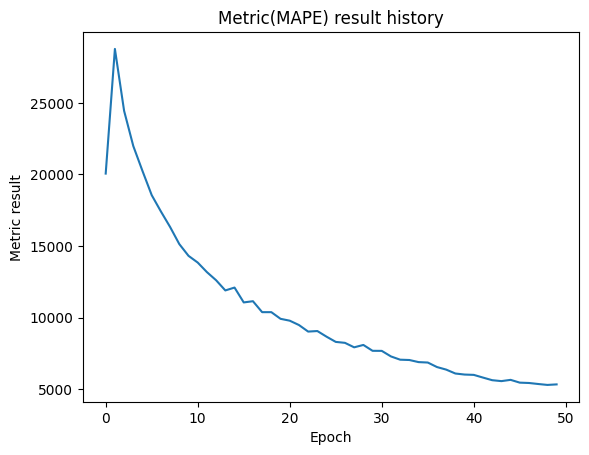

In [25]:
# Plot the history of loss
plt.plot(range(num_epochs), loss_info_RNN)
plt.title('Loss(MAE) history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the history of metric result
plt.plot(range(num_epochs), metric_info_RNN)
plt.title('Metric(MAPE) result history')
plt.xlabel('Epoch')
plt.ylabel('Metric result')
plt.show()

In [26]:
# Testing model's performance on our dataset
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [27]:
running_loss = 0.0                                             # MAE Loss
running_metric = 0.0                                           # MAPE metric

batch_size = 1
modPred_RNN = []
GroundTruth = []
for i in tqdm(range(0, len(x_test_tensor), batch_size), desc=f"Train set inference ..."):
  
        # Get batch of inputs and targets
        batch_x = x_test_tensor[i:i+batch_size]
        batch_y = y_test_tensor[i:i+batch_size]
        
        # Reshape input tensor
        batch_x = batch_x.view(-1, window_length, features)

        # Forward pass
        with torch.inference_mode():
            modelRNN.eval()
            outputs = modelRNN(batch_x)

        if batch_size == 1:
            loss = criterion(outputs.view(-1).to(outputs.device), batch_y.to(outputs.device))
            metric = metricc(outputs.view(-1).to(outputs.device), batch_y.to(outputs.device))
            if outputs.view(-1).cpu().detach() < 0:
                modPred_RNN.append(0)
            else: 
                modPred_RNN.append(outputs.view(-1).cpu().detach())
            GroundTruth.append(torch.tensor([batch_y]).cpu().detach())
        
        else:
            loss = criterion(outputs.view(-1), batch_y)
            metric = metricc(outputs.view(-1), batch_y)
            if outputs.view(-1).cpu().detach() < 0:
                modPred_RNN.append(0)
            else: 
                modPred_RNN.append(outputs.view(-1).cpu().detach())
            GroundTruth.append(batch_y.cpu().detach())
          
        running_loss += loss.item()
        running_metric += metric.item()

test_loss = running_loss / (len(x_train) / batch_size)
test_metric = running_metric / (len(x_train) / batch_size)
print("-"*25, "TEST LOSS", "-"*25)
print(f"Test MAE loss: {test_loss:.9f}")
print(f"Test MAPE metric: {test_metric:.9f}")

Train set inference ...:   0%|          | 0/480 [00:00<?, ?it/s]

------------------------- TEST LOSS -------------------------
Test MAE loss: 0.000499948
Test MAPE metric: 64.355210480


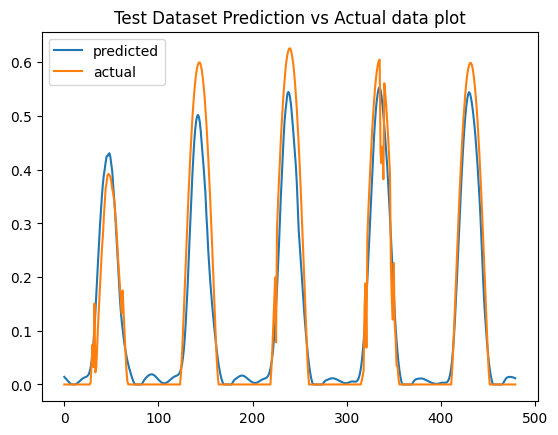

In [28]:
plt.plot(modPred_RNN)
plt.plot(GroundTruth)
plt.title('Test Dataset Prediction vs Actual data plot')
plt.legend(['predicted', 'actual'])
plt.show()